In [1]:
import pathlib
import pickle

import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import cmasher as cmr
from PIL import Image

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
import galstreams
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
from gala.units import galactic
from pyia import GaiaData
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import minimize
from tqdm.auto import tqdm

In [2]:
mwstreams = galstreams.MWStreams()

Initializing galstreams library from master_log... 


In [3]:
from ezpadova import parsec

Z = 10 ** (-2.2 + np.log10(0.0207))
iso = parsec.get_one_isochrone(12e9, Z, model="parsec12s", phot="panstarrs1")
iso = iso.to_astropy_table()

iso_gaia = parsec.get_one_isochrone(12e9, Z, model="parsec12s", phot="gaia")
iso_gaia = iso_gaia.to_astropy_table()
iso_gaia.remove_columns([x for x in iso_gaia.colnames if x in iso.colnames])

iso = at.hstack((iso, iso_gaia))

tmp_iso = iso[iso["stage"] == 4][1:]
HB_absmag = np.mean(tmp_iso["rP1"])

tmp_iso = iso[iso["stage"] == 1]
MSTO_absmag = tmp_iso["rP1"].min()

Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...


## Load data:

In [4]:
# tbl = at.Table.read("../data/Ibata2023_Table1.csv")
g = GaiaData(
    "../data/Ibata2023_GaiaDR3-xm.fits",
    radial_velocity_colname="vh",
    radial_velocity_unit=u.km / u.s,
)

In [5]:
tbl = at.Table.read("../data/ibata_streams_full.csv")
sID_to_name = {row["sID"]: row["name"] for row in at.unique(tbl, keys="sID")}

In [6]:
dist = g.get_distance(allow_negative=True)
dist[~np.isfinite(dist)] = 100 * u.kpc

c = g.get_skycoord(distance=dist)
# c = coord.SkyCoord(
#     ra=tbl["ra"] * u.deg,
#     dec=tbl["dec"] * u.deg,
#     distance=dist,
#     pm_ra_cosdec=tbl["mu_r"] * u.mas / u.yr,
#     pm_dec=tbl["mu_d"] * u.mas / u.yr,
#     radial_velocity=tbl["vh"] * u.km / u.s,
# )

In [7]:
gal = c.galactic

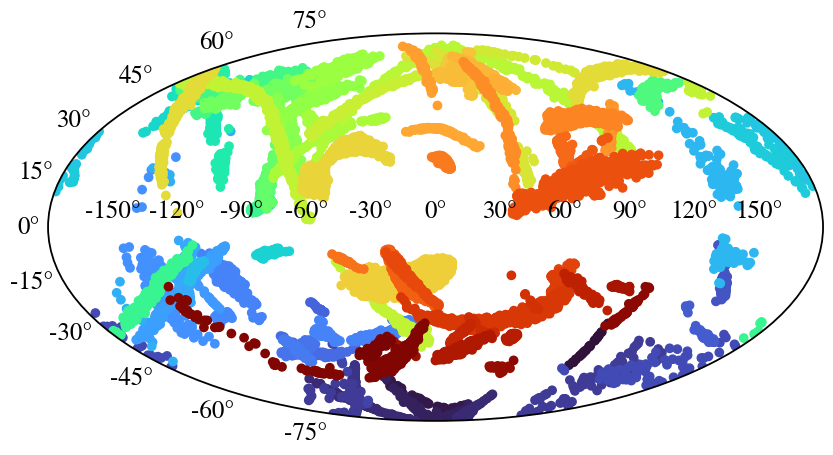

In [8]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": "aitoff"})
ax.scatter(gal.l.wrap_at(180 * u.deg).radian, gal.b.radian, c=tbl["sID"], cmap="turbo")

In [9]:
np.size(np.unique(tbl['sID'])), len(tbl)

(87, 24540)

In [10]:
tbl.colnames

['id_source',
 'ra',
 'dec',
 'plx',
 'mu_r',
 'mu_d',
 'Gmag0',
 'BRcol0',
 'vh',
 'evh',
 'vsource',
 'sID',
 'year',
 'name']

In [11]:
# kinematic census
names = np.unique(tbl['name'])

ind_pmra = tbl['mu_r']!=0
ind_pmdec = tbl['mu_d']!=0
ind_vr = tbl['vh']!=0

# distance
dist = np.zeros(len(tbl)) * u.kpc

for name in names[:]:
    ind = tbl['name']==name
    med_plx = np.median(tbl['plx'][ind])
    dist[ind] = med_plx**-1 * u.kpc
#     print(name, np.sum(ind), np.sum(ind & ind_pmra), np.sum(ind & ind_pmdec), np.sum(ind & ind_vr))

In [12]:
# c = coord.SkyCoord(ra=tbl['ra']*u.deg, dec=tbl['dec']*u.deg, distance=np.abs(tbl['plx']**-1)*u.kpc)
c = coord.SkyCoord(ra=tbl['ra']*u.deg, dec=tbl['dec']*u.deg, distance=dist)
cgal = c.transform_to(coord.Galactocentric())

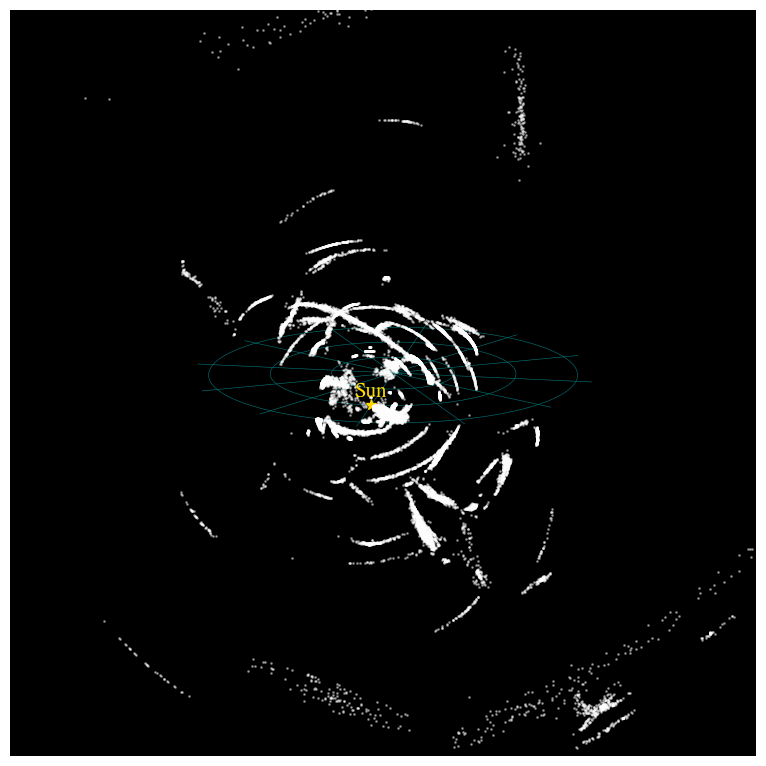

In [13]:
fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(projection='3d', facecolor='k')

elev, azim, roll = 20, -7, 0
elev, azim, roll = 15, 190, 0
# elev, azim, roll = 30, 190, 0
ax.view_init(elev, azim, roll)

radii = np.array([4,8,12])
theta = np.linspace(0,2*np.pi,100)

phi = np.arange(0,360,30)*u.deg
rlims = np.linspace(0,13,2)

teal = '#027b7c'
lw_grid = 0.4

############
# plot disk 
# circular
for r in radii:
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    z = theta * 0
    
    plt.plot(x, y, z, '-', color=teal, lw=lw_grid)

# radial
for p in phi:
    x = rlims * np.cos(p)
    y = rlims * np.sin(p)
    z = rlims * 0
    
    plt.plot(x, y, z, '-', color=teal, lw=lw_grid)

# the Sun
plt.plot(-8.1,0,0.02, '*', color='gold', ms=8)
plt.gca().text(-8.3,0,0.6,'Sun', ha='center', color='gold', fontsize='small')

###############
# plot streams

for name in names[:]:
    ind = tbl['name']==name
    plt.plot(cgal.x.value[ind], cgal.y.value[ind], cgal.z.value[ind], 'wo', ms=1, alpha=0.4)


#############
# axes setup
plt.gca().set_xlim(-15,15)
plt.gca().set_ylim(-15,15)
plt.gca().set_zlim(-5,5)
# plt.gca().set_xlim(-20,20)
# plt.gca().set_ylim(-20,20)
# plt.gca().set_zlim(-45,20)

# x_range = np.diff(ax.get_xlim())[0]
# y_range = np.diff(ax.get_ylim())[0]
# z_range = np.diff(ax.get_zlim())[0]
# ax.set_box_aspect([x_range, y_range, z_range])

plt.gca().set_aspect('equal')
plt.axis('off')

plt.tight_layout()
plt.savefig('../plots/fos3d_square.png', dpi=300, bbox_inches='tight', pad_inches=0)

# # crop (ugh!)
# # Open the image
# img = Image.open('../plots/fos3d_square.png')

# # Get the dimensions
# img_width, img_height = img.size

# # Define the coordinates for cropping (left, top, right, bottom)
# crop_box = (0, int(img_height*0.15), img_width, int(img_height*0.85))
# # print(crop_box, img_width, img_height)

# # Crop the image
# cropped_img = img.crop(crop_box)

# # Save the cropped image
# cropped_img.save('../plots/fos3d.png')

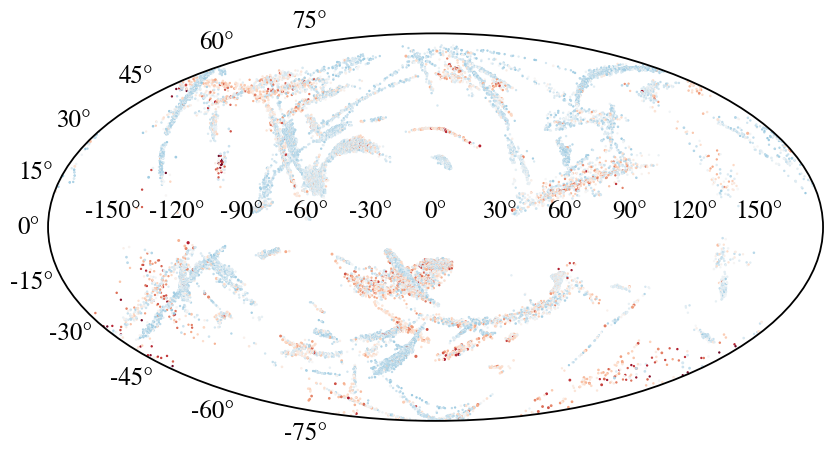

In [14]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": "aitoff"})
ax.scatter(gal.l.wrap_at(180 * u.deg).radian, gal.b.radian, s=(15/tbl['Gmag0'])**3, c=tbl["BRcol0"], cmap="RdBu_r",
          vmin=0., vmax=1.8)

(20.0, 12.0)

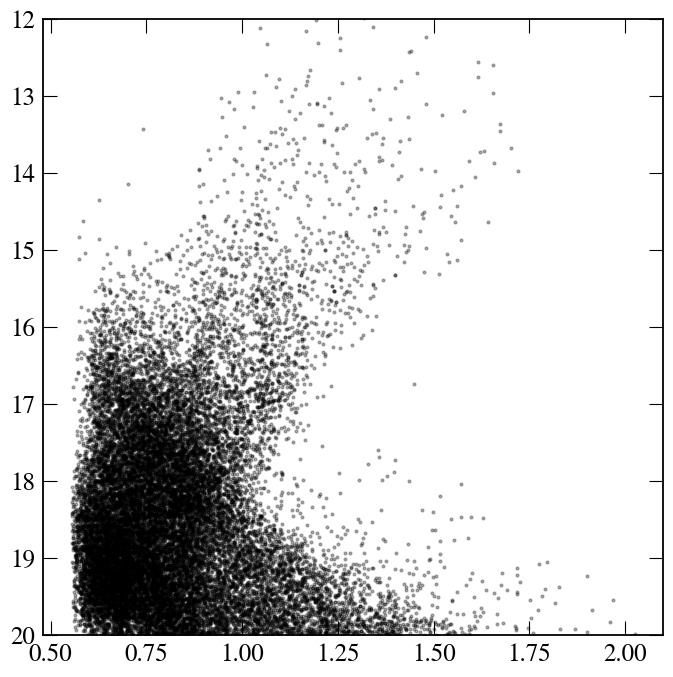

In [15]:
plt.plot(tbl['BRcol0'], tbl['Gmag0'], 'ko', ms=2, alpha=0.3)

plt.ylim(20,12)